# Tanzanian Water Wells

In [1]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

## Project Overview
Our group has been hired by Tanzania's Ministry of Water to develop a classification model that will assist Tanzania's Ministry of Water in predicting the status of the waterpoints they oversee. Although the waterpoint statuses could be described in a number of ways - e.g. whether it is functional but needs repair - our model will perform a binary classification to determine if the waterpoint is functioning as exepected or not.


## Business Problem
While the country of Tanzania has abundant water resources including Lake Victoria, the largest lake in Africa, nearly 50% of the waterpoints overseen by the Ministry of Water are non-functional, leaving large segments of the population without a reliable or potable source of water. The Ministry has decided to address this issue by having a predicitve model created that will allow them to identify the functionality of waterpoints. The model needed to take into consideration the fact that if wells were incorrectly identified as being functional then communities would be left without water, and conversely if the model identified working wells as broken the Ministry would not be able to allocate their resources effectively. Since this model is being used in a purely predictive context, its complexity is irrelevant -- it only matters how well it optimizes on these points. Since communities without water is the more tragic of the two considerations, we focused on optimizing for correctly identifying non-functional wells when they are indeed non-functional. This yielded our 'postive' target, being non-functional, as well as our metric, which is recall (true non-functional / (true non-functional + false functional)).

**Note:** 'well', 'pump', 'watersource', etc. etc. are all used interchangeably to refer to the target, which is its function status

## Data Understanding

This data comes to us from the major stakeholder -- the Tanzanian Ministry of Water. It is intended that our model be as accurate as possible for the data that we're given so that in the future, the Tanzanian government can use new data it has collected in order to predict the function state of a water pump for which it has data.

The data is a collection of information on each water pump, split into mostly descriptors and not much quantitative information.

### Columns

There are 40 columns in the dataset, not including our predictor feature 'status'. There are 31 categorical columns and 9 numeric columns. A description of the columns can be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list).



In [2]:
# import well status and data information
status = pd.read_csv('data/status.csv', index_col='id')
data = pd.read_csv('data/data.csv', index_col='id')

In [3]:
# merge both on pump id
df = pd.merge(status, data, on='id')

In [4]:
# drop duplicates
df.drop_duplicates(inplace=True)
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,functional,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,functional,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,non functional,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,functional,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
# status counts
df['status_group'].value_counts()

functional                 32237
non functional             22813
functional needs repair     4314
Name: status_group, dtype: int64

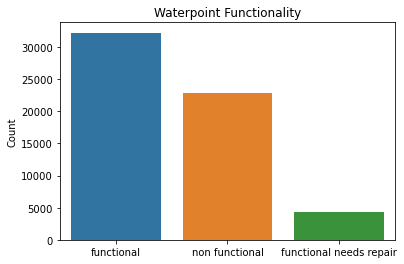

In [6]:
# visualize
fig, ax = plt.subplots()
sns.barplot(x=df['status_group'].value_counts().index, y=df['status_group'].value_counts(), ax=ax)
ax.set_title('Waterpoint Functionality')
ax.set_ylabel('Count')
plt.savefig('images/waterpoint_functionality_initial.png');

Based on the breakdown of the groups, we decided to turn our status column into a binary to make our classification process more straightforward. 

The 'functional needs repair' classification will be grouped in with the non-functional classification. The idea being, maintenance and repair will still be valuable on a damagaged waterpoint. It makes sense for our stakeholder to include in damaged waterpoints with this group because they are looking for where to direct their attention. It would be much more costly to the people of the area for a damaged waterpoint to be classified as completely functional and not get any additional attention (or water). 

In [7]:
# combine 'functional needs repair' into 'non functional'
df.loc[df['status_group'] == 'functional needs repair', 'status_group'] = 'non functional'

After our status combination, our split shows a much more balanced distribution of our data.

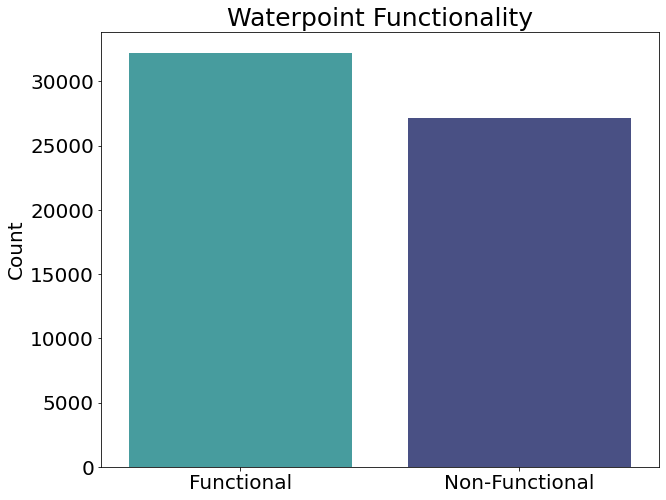

In [8]:
# Visualizing our breakdown

fig, ax = plt.subplots(figsize=(10,8))
plt.style.use('seaborn-talk')
palette = sns.color_palette("mako", n_colors = 2)
palette.reverse()
sns.barplot(x=df['status_group'].value_counts().index, y=df['status_group'].value_counts(),
           palette=palette)
ax.set_title('Waterpoint Functionality', fontsize=25)
ax.set_xticklabels(['Functional', 'Non-Functional'], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.savefig('images/waterpoint_functionality.png');

We can now start diving into our numerical and categorical columns, as well as looking for null values and other problematic values in the dataset.

In [9]:
# information on the full dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59364 non-null  object 
 1   amount_tsh             59364 non-null  float64
 2   date_recorded          59364 non-null  object 
 3   funder                 55729 non-null  object 
 4   gps_height             59364 non-null  int64  
 5   installer              55709 non-null  object 
 6   longitude              59364 non-null  float64
 7   latitude               59364 non-null  float64
 8   wpt_name               59364 non-null  object 
 9   num_private            59364 non-null  int64  
 10  basin                  59364 non-null  object 
 11  subvillage             58993 non-null  object 
 12  region                 59364 non-null  object 
 13  region_code            59364 non-null  int64  
 14  district_code          59364 non-null  int64  
 15

In [10]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59364.000000,59364.000000,59364.000000,5.936400e+04,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000
mean,317.843017,668.702513,34.097560,-5.709463e+00,0.474429,15.295516,5.631494,180.019086,1301.441227
std,2998.473133,693.131013,6.517065,2.943608e+00,12.239934,17.592619,9.636138,471.604294,951.369704
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.095187,-8.541904e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,370.000000,34.910318,-5.023822e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1320.000000,37.179490,-3.326918e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [11]:
# separate into numerical and categorical features
cat_cols = []
num_cols = []
for col in df.columns:
    if df[col].dtype in ['object']:
        cat_cols.append(col)
    else:
        num_cols.append(col)

We would like to get a better idea of the distribution of our numerical features.

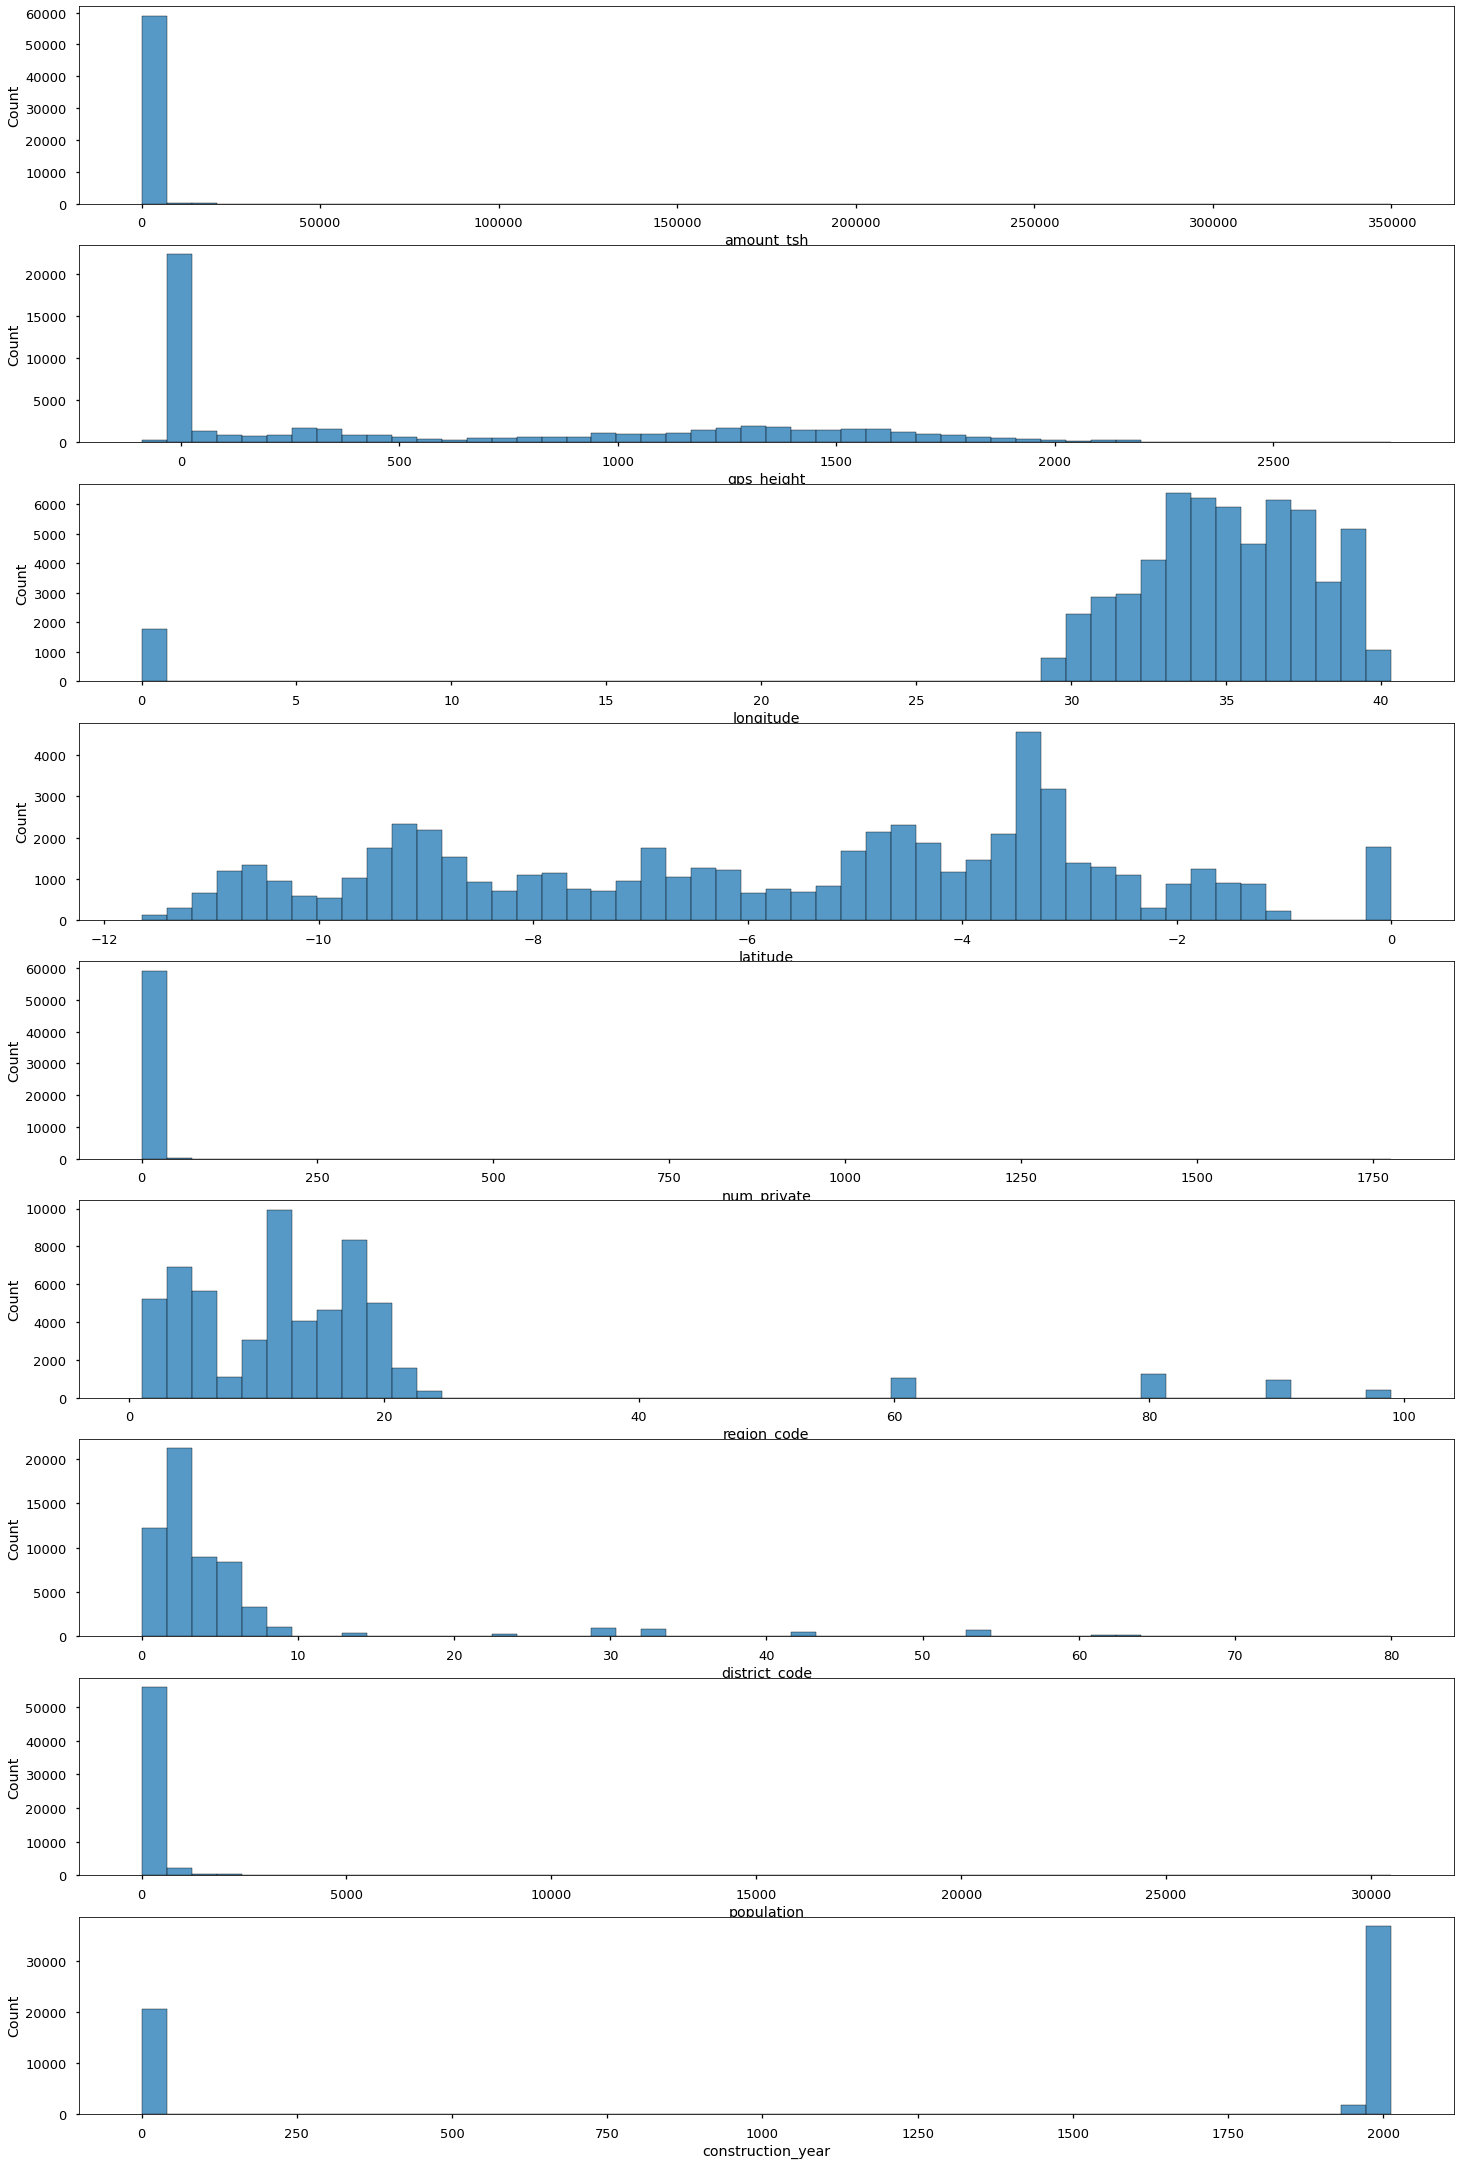

In [12]:
# visualize numericals
fig, axes = plt.subplots(nrows=len(num_cols),figsize=(20,30))
plt.tight_layout()
for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, ax=axes[i])

**Initial Numerical Column Impressions**

Very little of our numerical data can be classified as having a normal distribution. Because of this, we will avoid using a StandardScaler. We can see problems in our longitude data as it is not possible for there to be a longitude of 0 in Tanzania. We also see that there is a large proportion of 0 values in population and construction year that we will address later. 

It doesn't matter that `amount_tsh` has a large propportion of 0s. The data dictionary describes it as "amount_tsh - Total static head (amount water available to waterpoint)". This might seem quite bad, because this makes it sound like the total water available is 0 for over 70% of water points. However, this is an incorrect description for Total Static Head, as shown [here](../../notebooks/Nick/images/total_static_head.jpeg). It's simply the distance from the surface of the source to the surface of the access point, so actually having '0' is a good thing.

In [13]:
# percent 0 in each column
(df == 0).sum(axis=0)/len(data)*100

status_group              0.000000
amount_tsh               70.038721
date_recorded             0.000000
funder                    0.000000
gps_height               34.346801
installer                 0.000000
longitude                 2.991582
latitude                  0.000000
wpt_name                  0.000000
num_private              98.664983
basin                     0.000000
subvillage                0.000000
region                    0.000000
region_code               0.000000
district_code             0.038721
lga                       0.000000
ward                      0.000000
population               35.934343
public_meeting            8.508418
recorded_by               0.000000
scheme_management         0.000000
scheme_name               0.000000
permit                   29.410774
construction_year        34.803030
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

After reviewing the zeros in each category, we noticed that there are 0 values in the longitude column. There are no longitudinal coordinates in Tanzania with a value of zero. We know these values are errors so we will replace them and the latidudinal coordinates associated with them with NAN. 

In [14]:
# Number of rows with problem 0 longitude values 
(df['longitude'] == 0).sum()

1777

In [15]:
# All 0 longitude values have the same value count, showing us this is an error

df[df['longitude'] == 0]['latitude'].value_counts()

-2.000000e-08    1777
Name: latitude, dtype: int64

In [16]:
# transform incorrect long/lat to nulls 
df.loc[(df['longitude']== 0), ('longitude','latitude')] = np.nan

We also will transform our contruction year with a value of 0 to NAN. We do not want this 0 value to have a negative impact on our model so replacing it is necessary. 

In [17]:
# transform construction year 0 to nulls
df.loc[(df['construction_year']== 0), 'construction_year'] = np.nan

In [18]:
# check out upper tail of amount_tsh
df['amount_tsh'].sort_values(ascending=False).head(30)

id
41564    350000.0
4128     250000.0
7860     200000.0
70107    170000.0
54154    138000.0
15191    120000.0
71707    117000.0
15801    117000.0
64148    117000.0
38117    117000.0
18724    117000.0
7737     117000.0
4712     117000.0
45188    100000.0
10996    100000.0
69674    100000.0
65614     70000.0
58336     60000.0
24876     50000.0
13946     50000.0
35268     50000.0
3252      50000.0
73818     45000.0
28057     45000.0
30855     45000.0
40048     40000.0
73094     40000.0
28620     40000.0
48346     40000.0
50998     40000.0
Name: amount_tsh, dtype: float64

Although it is not indicated in our data description, we assume that the population is being measured in units of 100.

In [19]:
# check out upper tail of population
df['population'].sort_values(ascending=False).head(30)

id
12169    30500
49354    15300
30750    11463
21166    10000
63349    10000
56570    10000
33117     9865
18520     9500
16664     9000
69166     9000
17459     9000
72820     8848
2118      8600
42967     8500
41994     8200
42627     8000
64021     8000
6280      8000
36272     8000
61539     8000
11002     7530
13182     7500
60098     7500
11571     7500
9941      7000
15841     7000
29054     6922
19042     6922
50707     6922
55230     6922
Name: population, dtype: int64

In [20]:
# percent null in each column
df.isna().sum()/len(data)*100

status_group              0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.119529
gps_height                0.000000
installer                 6.153199
longitude                 2.991582
latitude                  2.991582
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.624579
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.579125
recorded_by               0.000000
scheme_management         6.526936
scheme_name              47.372054
permit                    5.144781
construction_year        34.803030
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

Looking through the characteristics of unique values in our columns as well as the number of unique values in each column. This is important because it will inform how we move forward with preprocessing.

In [21]:
#Looking through the characteristics of unique values in our columns
for col in df.columns:
    print(f'{col}:')
    print(df[col].value_counts(normalize=True))
    print(df[col].nunique())
    print('<>'*5)

status_group:
functional        0.54304
non functional    0.45696
Name: status_group, dtype: float64
2
<><><><><>
amount_tsh:
0.0         0.700812
500.0       0.052254
50.0        0.041641
1000.0      0.025066
20.0        0.024645
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64
98
<><><><><>
date_recorded:
3/15/2011    0.009635
3/17/2011    0.009400
2/3/2013     0.009197
3/14/2011    0.008760
3/16/2011    0.008642
               ...   
7/1/2004     0.000017
1/25/2012    0.000017
8/30/2011    0.000017
8/31/2011    0.000017
3/6/2004     0.000017
Name: date_recorded, Length: 356, dtype: float64
356
<><><><><>
funder:
Government Of Tanzania     0.162860
Danida                     0.055878
Hesawa                     0.039441
Rwssp                      0.024619
World Bank                 0.024206
                             ...   
Said Hashim                0.000018
Fre

Name: extraction_type_class, dtype: float64
7
<><><><><>
management:
vwc                 0.682114
wug                 0.109410
water board         0.049407
wua                 0.042703
private operator    0.033202
parastatal          0.029749
water authority     0.015228
other               0.014217
company             0.011539
unknown             0.009450
other - school      0.001668
trust               0.001314
Name: management, dtype: float64
12
<><><><><>
management_group:
user-group    0.883633
commercial    0.061283
parastatal    0.029749
other         0.015885
unknown       0.009450
Name: management_group, dtype: float64
5
<><><><><>
payment:
never pay                0.426807
pay per bucket           0.151338
pay monthly              0.139815
unknown                  0.137019
pay when scheme fails    0.065932
pay annually             0.061350
other                    0.017738
Name: payment, dtype: float64
7
<><><><><>
payment_type:
never pay     0.426807
per bucket    0.151338
m

In [22]:
#Dialing in on the specifics of just our categorical columns
for col in cat_cols:
    print(f'{col}:')
    print(df[col].value_counts(normalize=True))
    print('<>'*5)

status_group:
functional        0.54304
non functional    0.45696
Name: status_group, dtype: float64
<><><><><>
date_recorded:
3/15/2011    0.009635
3/17/2011    0.009400
2/3/2013     0.009197
3/14/2011    0.008760
3/16/2011    0.008642
               ...   
7/1/2004     0.000017
1/25/2012    0.000017
8/30/2011    0.000017
8/31/2011    0.000017
3/6/2004     0.000017
Name: date_recorded, Length: 356, dtype: float64
<><><><><>
funder:
Government Of Tanzania     0.162860
Danida                     0.055878
Hesawa                     0.039441
Rwssp                      0.024619
World Bank                 0.024206
                             ...   
Said Hashim                0.000018
Fresh Water Plc England    0.000018
Serian                     0.000018
Drwssp                     0.000018
Tasaf Ii                   0.000018
Name: funder, Length: 1897, dtype: float64
<><><><><>
installer:
DWE                         0.312068
Government                  0.032634
RWE                         

In [23]:
# A quick look at our row value count, unique value count
# top category and freqency of that top category for each categorical feature 
df[cat_cols].describe()

,status_group,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59364,59364,55729,55709,59364,59364,58993,59364,59364,59364,56050,59364,55487,31225,56308,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364
unique,2,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,functional,3/15/2011,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,32237,572,9076,17385,3561,10212,505,5294,2503,307,50996,59364,36779,682,38838,26776,26776,26776,40493,52456,25337,25337,50785,50785,33165,33165,17020,17020,45764,28516,34615


In [24]:
#Checking for hidden empty values
((df[cat_cols] == 'None')|(df[cat_cols] == 'none')).sum(axis=0)/len(data)*100

status_group             0.000000
date_recorded            0.000000
funder                   0.003367
installer                0.000000
wpt_name                 5.998316
basin                    0.000000
subvillage               0.000000
region                   0.000000
lga                      0.000000
ward                     0.000000
public_meeting           0.000000
recorded_by              0.000000
scheme_management        0.001684
scheme_name              1.126263
permit                   0.000000
extraction_type          0.000000
extraction_type_group    0.000000
extraction_type_class    0.000000
management               0.000000
management_group         0.000000
payment                  0.000000
payment_type             0.000000
water_quality            0.000000
quality_group            0.000000
quantity                 0.000000
quantity_group           0.000000
source                   0.000000
source_type              0.000000
source_class             0.000000
waterpoint_typ

In [25]:
((df[cat_cols] == 'Unknown')|(df[cat_cols] == 'unknown')).sum(axis=0)/len(data)*100

status_group              0.000000
date_recorded             0.000000
funder                    0.006734
installer                 0.006734
wpt_name                  0.005051
basin                     0.000000
subvillage                0.000000
region                    0.000000
lga                       0.000000
ward                      0.000000
public_meeting            0.000000
recorded_by               0.000000
scheme_management         0.000000
scheme_name               0.000000
permit                    0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.944444
management_group          0.944444
payment                  13.693603
payment_type             13.693603
water_quality             3.153199
quality_group             3.153199
quantity                  1.328283
quantity_group            1.328283
source                    0.111111
source_type               0.000000
source_class        

In [26]:
df[cat_cols].isna().sum()

status_group                 0
date_recorded                0
funder                    3635
installer                 3655
wpt_name                     0
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            3314
recorded_by                  0
scheme_management         3877
scheme_name              28139
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
dtype: int64

In [27]:
(df[cat_cols] == 0).sum()

status_group                 0
date_recorded                0
funder                       0
installer                    0
wpt_name                     0
basin                        0
subvillage                   0
region                       0
lga                          0
ward                         0
public_meeting            5054
recorded_by                  0
scheme_management            0
scheme_name                  0
permit                   17470
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
dtype: int64

After spending time looking for a variety of representations of empty or null values in our categorical columns, we replace them all with Unknown for better categorization.

In [28]:
df[cat_cols] = df[cat_cols].replace(to_replace=['none','None','unknown', 0, np.nan],
                                    value='Unknown')

In [29]:
(df[cat_cols] == 'Unknown').sum()

status_group                 0
date_recorded                0
funder                    3641
installer                 3659
wpt_name                  3566
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            8368
recorded_by                  0
scheme_management         3878
scheme_name              28808
permit                   20526
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                 561
management_group           561
payment                   8134
payment_type              8134
water_quality             1873
quality_group             1873
quantity                   789
quantity_group             789
source                      66
source_type                  0
source_class               277
waterpoint_type              0
waterpoint_type_group        0
dtype: int64

We can now more accurately understand how unknown or empty values are represented in each feature across our dataset. 

As we explore the data, we will unpack some of the meaning behind the data and look for columns that are not relevant to our model. We are also now able to make decisions on dealing with the kept data. We used the data that was the most descriptive because our best-performing model downstream is able handle large amounts of categorical information. 

## Categorical feature determinations:

### Dropped Columns

The following columns will be dropped because they contain an exact duplicate of an existing column or data that is better represented in another column. 

- num_private
- region_code 
- district_code
- date_recorded 
- wpt_name
- recorded_by 
- scheme_name
- extraction_type_group
- extraction_type_class
- management_group
- payment_type
- quality_group
- quantity_group
- source_type
- source_class
- waterpoint_type_group

### OneHotEncoder Processing
The following columns have less than 25 unique values, making them good candidates for [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). The cutoff criteria was set to keep our post processing column count from getting too large relative to our number of rows in our dataset.

- basin
- region
- public_meeting
- scheme_management
- permit
- extraction_type
- management
- payment
- water_quality
- quantity
- source
- waterpoint_type

### Categorical Encoder Processing  

The following features have over 100 unique value counts, making them poor candidates for OneHotEncoder. To preserve the size of our post processing dataset we used [Count Encoding](https://contrib.scikit-learn.org/category_encoders/count.html). 

- funder 
- installer
- subvillage
- lga 
- ward

### Numerical Processing

Because our numerical data holds non-normal distributions, we used a [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to standardize our data. We also used an [Iterative Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) to deal with the few null values we identified.

- amount_tsh
- gps_height
- longitude
- latitude
- population
- construction_year


In [30]:
drop_cols = ['num_private', 'region_code', 'district_code', 'date_recorded', 'wpt_name',
             'recorded_by', 'scheme_name', 'extraction_type_group', 'extraction_type_class',
             'management_group', 'payment_type', 'quality_group', 'quantity_group',
             'source_type', 'source_class', 'waterpoint_type_group']
df_post = df.drop(columns=drop_cols)

We are making our status column binary for usability. 

In [31]:
# binary encode status_group into `non_functional` with 1 = non_functional, 0 = functional
df_post.rename(columns={'status_group':'non_functional'}, inplace=True)
df_post['non_functional']\
= df_post['non_functional'].apply(lambda x: 1 if x == 'non functional' else 0)

In [32]:
df_post.to_csv('data/data_cleaned.csv')

## Limitations

Overall, this data does a half-way serviceable job of presenting features that have relevance to the target functionality state. It's decently clean, and it presents geographical information, data about the well itself, the water that flows through it, and the groups involved in its operation. However, it's also not as ideal as it could be. We don't get a lot of information from the few numerical features, especially not as much as we would expect from this type of column. Furthermore, some categorical features like those relating to the water could probably be much more valuable if they were presented as quantifiable information. The huge proportion of categorical features in comparison to the numerical would suggest that the best model for this data would be non-parametric, as parametric models tend to perform better with a higher proportion of numerical features.

While our model might perform decently well with the provided data, I would strongly suggest that the Government of Tanzania revisit their data collection methods to provide more robust and predictive information.